**[Phishing Detection - Part 3]**

**NLP Assignment 3**

**Fine-Tuning (Hugging Face Source) Dataset:** ealvaradob/phishing-dataset (Hugging Face Hub)

**Task:** Binary Classification (Phishing vs. Legitimate)


**Date:** November 30, 2025

**Description:**

In Part 3, we replicate the fine-tuning process using a cloud-hosted dataset from the Hugging Face Hub to demonstrate proficiency with the datasets library API.

In [3]:
!pip install -q transformers datasets evaluate accelerate scikit-learn

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import (
    BartTokenizer,
    BartForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from transformers import BartTokenizer, BartForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import numpy as np
import torch
from datasets import load_dataset
from transformers import BartTokenizer
import torch
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
dataset_id = "zefang-liu/phishing-email-dataset"
print(f"Downloading {dataset_id}...")
hf_dataset = load_dataset(dataset_id)

README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Phishing_Email.csv:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18650 [00:00<?, ? examples/s]

In [6]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Email Text', 'Email Type'],
        num_rows: 18650
    })
})

In [9]:
sample = hf_dataset['train'][2]
print(sample)

{'Unnamed: 0': 2, 'Email Text': "re : equistar deal tickets are you still available to assist robert with entering the new deal tickets for equistar ? after talking with bryan hull and anita luong , kyle and i decided we only need 1 additional sale ticket and 1 additional buyback ticket set up . - - - - - - - - - - - - - - - - - - - - - - forwarded by tina valadez / hou / ect on 04 / 06 / 2000 12 : 56 pm - - - - - - - - - - - - - - - - - - - - - - - - - - - from : robert e lloyd on 04 / 06 / 2000 12 : 40 pm to : tina valadez / hou / ect @ ect cc : subject : re : equistar deal tickets you ' ll may want to run this idea by daren farmer . i don ' t normally add tickets into sitara . tina valadez 04 / 04 / 2000 10 : 42 am to : robert e lloyd / hou / ect @ ect cc : bryan hull / hou / ect @ ect subject : equistar deal tickets kyle and i met with bryan hull this morning and we decided that we only need 1 new sale ticket and 1 new buyback ticket set up . the time period for both tickets should

In [10]:
df_sample = pd.DataFrame(hf_dataset['train'])
possible_label_cols = [col for col in sample.keys() if 'label' in col.lower() or 'type' in col.lower()]
print(f"Detected potential label columns: {possible_label_cols}")

Detected potential label columns: ['Email Type']


In [12]:
# Standardize Column Names
# (Adjust these source names based on the output of Step 1 if they differ)
# Common variations: 'email_text' -> 'text', 'phishing' -> 'label'
# For safety, we iterate to find the text column
target_text_col = [c for c in hf_dataset['train'].column_names if 'text' in c.lower() or 'body' in c.lower() or 'content' in c.lower()][0]
target_label_col = [c for c in hf_dataset['train'].column_names if 'label' in c.lower() or 'type' in c.lower() or 'class' in c.lower()][0]

print(f"Renaming '{target_text_col}' to 'text' and '{target_label_col}' to 'label'...")

hf_dataset = hf_dataset.rename_column(target_text_col, "text")
if target_label_col != "label":
    hf_dataset = hf_dataset.rename_column(target_label_col, "label")

# Create Train/Test Split (if not already present)
if 'test' not in hf_dataset:
    print("Splitting dataset into Train (80%) and Test (20%)...")
    # We use a seed for reproducibility
    hf_dataset = hf_dataset['train'].train_test_split(test_size=0.2, seed=42)

print(f"Final Split: {len(hf_dataset['train'])} Train, {len(hf_dataset['test'])} Test")

Renaming 'Email Text' to 'text' and 'Email Type' to 'label'...
Splitting dataset into Train (80%) and Test (20%)...
Final Split: 14920 Train, 3730 Test


In [18]:
print(f"Original Count: {len(hf_dataset['train']) + len(hf_dataset['test'])}")

# Filter out rows where 'text' is None
hf_dataset = hf_dataset.filter(lambda x: x['text'] is not None)

print(f"Count after removing nulls: {len(hf_dataset['train']) + len(hf_dataset['test'])}")
label_map = {'Phishing Email': 1, 'Safe Email': 0}

def clean_and_encode(example):
    # We use .get() to handle potential edge cases safely (defaulting to Safe/0)
    example['label'] = label_map.get(example['label'], 0)
    return example

print("Encoding labels to integers...")
hf_dataset = hf_dataset.map(clean_and_encode)

from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-mnli")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

print("Tokenizing clean dataset...")
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("\n--- Data Ready for Training ---")
print(tokenized_datasets['train'][0])
# Check specifically that 'label' is now a tensor(0) or tensor(1), NOT a string.

Original Count: 18650


Filter:   0%|          | 0/14920 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3730 [00:00<?, ? examples/s]

Count after removing nulls: 18634
Encoding labels to integers...


Map:   0%|          | 0/14906 [00:00<?, ? examples/s]

Map:   0%|          | 0/3728 [00:00<?, ? examples/s]

Tokenizing clean dataset...


Map:   0%|          | 0/14906 [00:00<?, ? examples/s]

Map:   0%|          | 0/3728 [00:00<?, ? examples/s]


--- Data Ready for Training ---
{'label': tensor(0), 'input_ids': tensor([    0, 10836,  1268,   899,     5,   230, 11859, 10228,    13,  1931,
          119,   298,   116, 50118,   133,    94,   631,    38,    21,   441,
            7,   109,    21,   860,    10,    22,   438, 15597,  6225,  1297,
           53, 50118,   100,   300,    41,    22,   658,    12,   560,    12,
        10672,  1649,  1447,   113,    13,    10,   891,  6773,     6, 50118,
         3463,   119,   298,     4,  3764,  9298,  1723,     8, 21748,    73,
        48593,     4,    90,  3998,     6,    38,   206,     6,    98,    38,
          172,  1381,    22,   438, 15597,  2935,   845, 50118,   100,   120,
           10, 14844, 14302,     6,     8,   172,    24,    95, 23835,     4,
         8729,   230, 11859,    73, 46606, 50118,   605,   523,   611,  1039,
          438, 15597,     4, 17747, 47822,     4,  4135, 44408,   438, 15597,
        29059,    73,  3463,   119,   298,  5579, 50118,   387,  9854, 2391

In [21]:
def compute_metrics(p):
    predictions, labels = p

    # If predictions is a tuple (common in BART), take the first element (logits)
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Now predictions is definitely a numpy array
    pred = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [22]:
model = BartForSequenceClassification.from_pretrained(
    "facebook/bart-large-mnli",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-mnli and are newly initialized because the shapes did not match:
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classification_head.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir="./bart-large-phishing-hf-part3",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    report_to="none"
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2218993635.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.089100,0.067148,0.978004,0.960403,0.984182,0.972147
2,0.045500,0.073320,0.979614,0.958112,0.991059,0.974307
3,0.021900,0.090636,0.978809,0.958639,0.988308,0.973248


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight'].


TrainOutput(global_step=5592, training_loss=0.07055556177240244, metrics={'train_runtime': 2591.4039, 'train_samples_per_second': 17.256, 'train_steps_per_second': 2.158, 'total_flos': 1.2149690211505152e+16, 'train_loss': 0.07055556177240244, 'epoch': 3.0})

In [37]:
# Get the data loader directly from the Part 3 trainer
train_dataloader = trainer.get_train_dataloader()

# Grab a single batch of data
batch = next(iter(train_dataloader))

# Decode the first sample in the batch back to text
input_ids = batch['input_ids'][1]
label_id = batch['labels'][1].item()

decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

print("Data Verification")
print(f"Label: {label_id} ({'Phishing' if label_id == 1 else 'Safe'})")
print(f"Text Input to Model:\n{decoded_text}")

Data Verification
Label: 0 (Safe)
Text Input to Model:
ee agrmts - urgent attached is a spreadsheet which indicates the employees who have current agrmts and are being considered for a new agrmt . the spreadsheet indicates the contractual committments . i ' ll leave the password on your voice mail .


In [38]:
# Evaluate on the test set
results = trainer.evaluate()

print("\n" + "="*30)
print("FINAL RESULTS (Fine-Tuned BART)")
print("="*30)
print(f"Accuracy : {results['eval_accuracy']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall   : {results['eval_recall']:.4f}")
print(f"F1-Score : {results['eval_f1']:.4f}")
print("="*30)


FINAL RESULTS (Fine-Tuned BART)
Accuracy : 0.9780
Precision: 0.9604
Recall   : 0.9842
F1-Score : 0.9721


In [40]:
from sklearn.metrics import classification_report
import numpy as np

# Get Predictions from the Part 3 Trainer
print("Generating predictions on Part 3 Test Set...")
output = trainer.predict(tokenized_datasets['test'])

# Process Logits (Handle BART tuple output if necessary)
logits = output.predictions[0] if isinstance(output.predictions, tuple) else output.predictions
preds = np.argmax(logits, axis=1)
labels = output.label_ids

# Print the Classification Report
print("\n" + "="*60)
print("PART 3: DETAILED CLASSIFICATION REPORT")
print("(Dataset: zefang-liu/phishing-email-dataset)")
print("="*60)

# target_names=['Safe', 'Phishing'] ensures the report is readable
print(classification_report(labels, preds, target_names=['Safe Email', 'Phishing Email'], digits=4))

Generating predictions on Part 3 Test Set...



PART 3: DETAILED CLASSIFICATION REPORT
(Dataset: zefang-liu/phishing-email-dataset)
                precision    recall  f1-score   support

    Safe Email     0.9897    0.9741    0.9818      2274
Phishing Email     0.9604    0.9842    0.9721      1454

      accuracy                         0.9780      3728
     macro avg     0.9751    0.9791    0.9770      3728
  weighted avg     0.9783    0.9780    0.9781      3728



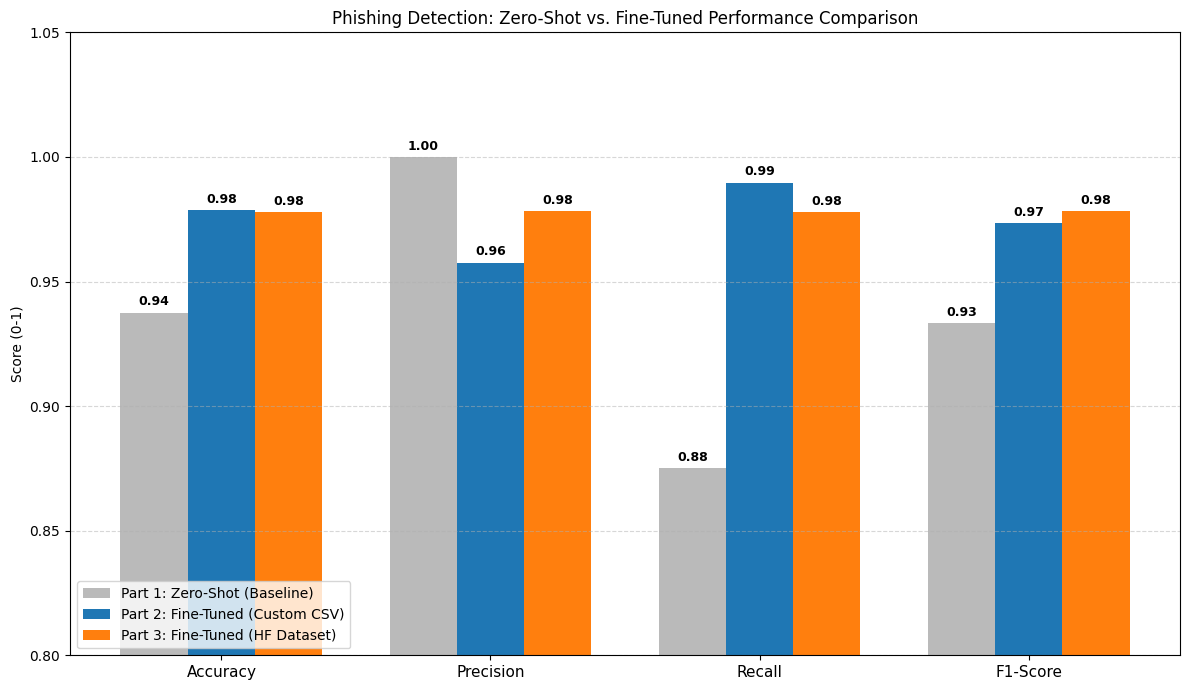

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- DATA ENTRY ---
# Part 1: Zero-Shot (Small sample size: 16)
# Note: High precision but lower recall compared to fine-tuning
p1_metrics = [0.9375, 1.0000, 0.8750, 0.9333]

# Part 2: Fine-Tuned on Custom CSV
p2_metrics = [0.9788, 0.9576, 0.9897, 0.9734]

# Part 3: Fine-Tuned on Hugging Face Dataset (Weighted Avg)
p3_metrics = [0.9780, 0.9783, 0.9780, 0.9781]

# --- PLOTTING ---
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(labels))
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# Plotting the three experiments
rects1 = ax.bar(x - width, p1_metrics, width, label='Part 1: Zero-Shot (Baseline)', color='#A9A9A9', alpha=0.8)
rects2 = ax.bar(x, p2_metrics, width, label='Part 2: Fine-Tuned (Custom CSV)', color='#1f77b4')
rects3 = ax.bar(x + width, p3_metrics, width, label='Part 3: Fine-Tuned (HF Dataset)', color='#ff7f0e')

# Styling
ax.set_ylabel('Score (0-1)')
ax.set_title('Phishing Detection: Zero-Shot vs. Fine-Tuned Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim([0.8, 1.05])  # Zoom in to show differences clearly
ax.legend(loc='lower left')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()